<table style="margin-left: 0;">
    <tr>
        <td colspan="5" style="text-align: center;"><h2><b>Portfolio 3 - Deep Learning</b></h2></td>
    </tr>
    <tr>
        <th>Coach</th>
        <th>Opdrachtnummer</th>
        <th>Namen groepsleden</th>
    </tr>
    <tr>
        <td><span style="color:blue">Vikram en Bob</span></td>
        <td align="center"><span style="color:blue">3</span></td>
        <td>
            <ul style="list-style-type:none; padding-left:0;">
                <li><b>Mark Olieman:</b> <span style="color:green">19054033</span></li>
                <li><b>Johan Heskes:</b> <span style="color:green">22132376</span></li>
                <li><b>Henry Lau:</b> <span style="color:green">22122958</span></li>
                <li><b>Isa Dijkstra:</b> <span style="color:green">22119485</span></li>
            </ul>
        </td>
    </tr>
</table>

    
    
## Inhoudsopgave

- [**Inleiding**](#inleiding)
- [**Packages en de data inladen**](#data)
- [**Opdracht 1: Exploratieve Data Analyse**](#eda)
- [**Opdracht 2: Objectdetectie**](#objectdetectie)
- [**Opdracht 3: Ondertiteling van afbeeldinge**](#ondertiteling)
- [**Opdracht 4: Beeldgeneratie**](#beeldgeneratie)
- [**Opdracht 5: Implementatie**](#implementatie)
- [**Opdracht 6: Conclusie en aanbevelingen**](#conclusie)
- [**Bronnenlijst**](#bronnenlijst)

## Inleiding <a name='inleiding'></a>

In dit notebook....

## Packages en de data inladen <a name='data'></a>

In [1]:
import os
import random

In [2]:
import os
from PIL import Image

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isfile(path):
            try:
                img = Image.open(path)
                images.append(img)
            except Exception as e:
                print(f"Unable to load image {filename}: {e}")
    return images

path = "Train/images"
images = load_images(path)


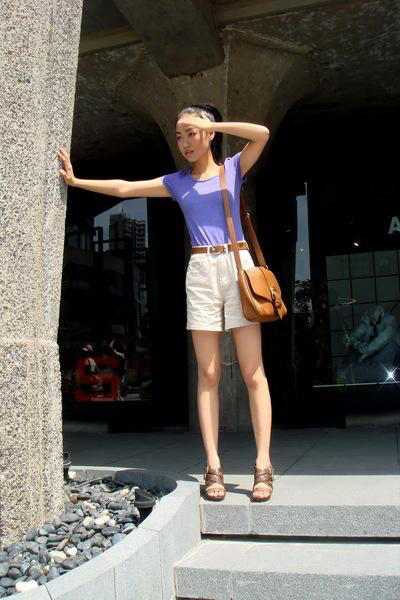

In [3]:
random_image = random.choice(images)
display(random_image)

In [4]:
import os

def load_text_files(folder):
    texts = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isfile(path) and path.endswith('.txt'):
            try:
                with open(path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    texts.append(content)
            except Exception as e:
                print(f"Unable to load file {filename}: {e}")
    return texts

folder_path = 'Train/labels'
text_files_content = load_text_files(folder_path)



In [5]:
random_text = random.choice(text_files_content)
display(random_text)

'8 0.591250 0.756667 0.242500 0.273333\n2 0.423750 0.305833 0.482500 0.245000\n7 0.428750 0.449167 0.332500 0.418333\n9 0.468750 0.896667 0.137500 0.153333'

In [6]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Definieer het pad naar de afbeeldingen en annotaties
image_dir = 'Train/images/'  # Path to the directory containing images
labels_dir = 'Train/labels/'  # Path to the directory containing annotation text files

# Functie om annotaties in te lezen
def read_labels(lables_path):
    with open(labels_path, 'r') as file:
        lines = file.readlines()
    
    labels = []
    for line in lines:
        parts = line.strip().split()
        item_klasse = int(parts[0])
        x_center_norm = float(parts[1])
        y_center_norm = float(parts[2])
        breedte_norm = float(parts[3])
        hoogte_norm = float(parts[4])
        labels.append((item_klasse, x_center_norm, y_center_norm, breedte_norm, hoogte_norm))
    
    return labels

# Functie om genormaliseerde waarden om te zetten naar pixelwaarden
def denormalize_bbox(image_width, image_height, bbox):
    item_class, x_center_norm, y_center_norm, width_norm, height_norm = bbox
    x_center = x_center_norm * image_width
    y_center = y_center_norm * image_height
    width = width_norm * image_width
    height = height_norm * image_height
    x = x_center - (width / 2)
    y = y_center - (height / 2)
    return item_class, x, y, width, height

# Lijst van item klassen
item_classes = ["sunglass", "hat", "jacket", "shirt", "pants", "shorts", "skirt", "dress", "bag", "shoe"]

# Kies een willekeurige afbeelding en de bijbehorende annotaties om te visualiseren
image_files = os.listdir(image_dir)
sample_image_file = image_files[1]  # Je kunt willekeurig kiezen of een andere manier om te selecteren

image_path = os.path.join(image_dir, sample_image_file)
labels_path = os.path.join(labels_dir, sample_image_file.replace('.jpg', '.txt'))

# Lees de afbeelding en de annotaties
image = Image.open(image_path)
image_width, image_height = image.size
labels = read_labels(labels_path)

# Zet genormaliseerde bounding boxes om naar pixelwaarden
bboxes = [denormalize_bbox(image_width, image_height, bbox) for bbox in labels]


In [8]:
import os
import cv2
import numpy as np

# Functie om annotaties in te lezen
def read_labels(labels_path):
    boxes = []
    with open(labels_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            item_class = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            boxes.append([item_class, x_center, y_center, width, height])
    return np.array(boxes)

# Functie om afbeeldingen en labels in te lezen
def load_data(image_dir, labels_dir):
    image_files = os.listdir(image_dir)
    images = []
    targets = []

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(labels_dir, img_name.replace('.jpg', '.txt'))
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = [denormalize_bbox(image_width, image_height, bbox) for bbox in labels]
        
        images.append(image)
        targets.append(boxes)
    
    return images, targets

# Functie om afbeeldingen voor te bewerken
def preprocess_images(images):
    resized_images = [cv2.resize(image, (416, 416)) for image in images]
    normalized_images = [image.astype(np.float32) / 255.0 for image in resized_images]
    return normalized_images

# Inlezen en voorbewerken van data
image_dir = 'Train/images'
labels_dir = 'Train/labels'
images, targets = load_data(image_dir, labels_dir)
#images = preprocess_images(images)



In [9]:
from sklearn.model_selection import train_test_split

# Split de dataset in train en validatie
train_images, val_images, train_targets, val_targets = train_test_split(images, targets, test_size=0.2, random_state=42)


## Opdracht 1: Exploratieve Data Analyse <a name='eda'></a>

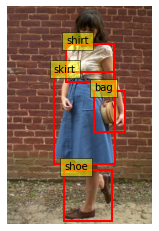

In [10]:
# Functie om afbeelding met bounding boxes te plotten
def plot_image_with_bboxes(image, bboxes, item_classes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in bboxes:
        item_class, x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y, item_classes[item_class], bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Plot de afbeelding met bounding boxes
plot_image_with_bboxes(image, bboxes, item_classes)


## Opdracht 2: Objectdetectie <a name='objectdetectie'></a>

In [12]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Model opzetten
model = Sequential()

# Voeg lagen toe aan het model
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l1'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# Model compileren
model.compile(optimizer='adam', loss='mape')

epochs = 10

import numpy as np

# Converteer train_images en val_images naar NumPy-arrays
train_images_np = np.array(train_images)
val_images_np = np.array(val_images)

# Converteer train_targets en val_targets naar NumPy-arrays
train_targets_np = np.array(train_targets)
val_targets_np = np.array(val_targets)

# Model trainen
history = model.fit(train_images_np, train_targets_np, epochs=epochs, validation_data=(val_images_np, val_targets_np))

# Haal trainings- en validatieloss op
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print de laagst behaalde validatieloss
min_val_loss = min(history.history['val_loss'])
print("Laagst behaalde validatieloss:", min_val_loss)

# Model samenvatting
model.summary()


MemoryError: Unable to allocate 1.15 GiB for an array with shape (1716, 600, 400, 3) and data type uint8

In [13]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Split the dataset into train and validation
train_images, val_images, train_targets, val_targets = train_test_split(images, targets, test_size=0.2, random_state=42)

# Convert lists to numpy arrays
train_images_np = np.array(train_images)
val_images_np = np.array(val_images)
train_targets_np = np.array(train_targets)
val_targets_np = np.array(val_targets)

# Create ImageDataGenerator objects
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Create generator objects for train and validation data
train_generator = train_datagen.flow(train_images_np, train_targets_np, batch_size=batch_size)
val_generator = val_datagen.flow(val_images_np, val_targets_np, batch_size=batch_size)

# Model opzetten
model = Sequential()

# Voeg lagen toe aan het model
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l1'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# Model compileren
model.compile(optimizer='adam', loss='mape')

epochs = 10


# Train the model using fit_generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator))


MemoryError: Unable to allocate 1.15 GiB for an array with shape (1716, 600, 400, 3) and data type uint8

In [14]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Split the dataset into train and validation
train_images, val_images, train_targets, val_targets = train_test_split(images, targets, test_size=0.2, random_state=42)

# Create ImageDataGenerator objects
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Train generator
train_generator = train_datagen.flow(train_images, train_targets, batch_size=batch_size)

# Validation generator
val_generator = val_datagen.flow(val_images, val_targets, batch_size=batch_size)

# Train the model using fit_generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_images) // batch_size)


ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (600, 400, 3), y.shape = (1716, 4, 5)

In [15]:
# Filter out images without corresponding targets
filtered_images = []
filtered_targets = []
for img, target in zip(images, targets):
    if len(target) > 0:  # Check if the target list is not empty
        filtered_images.append(img)
        filtered_targets.append(target)

# Convert lists to numpy arrays
images_np = np.array(filtered_images)
targets_np = np.array(filtered_targets)

# Split the dataset into train and validation
train_images, val_images, train_targets, val_targets = train_test_split(images_np, targets_np, test_size=0.2, random_state=42)

# Create ImageDataGenerator objects
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Train generator
train_generator = train_datagen.flow(train_images, train_targets, batch_size=batch_size)

# Validation generator
val_generator = val_datagen.flow(val_images, val_targets, batch_size=batch_size)

# Train the model using fit_generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_images) // batch_size)


MemoryError: Unable to allocate 1.44 GiB for an array with shape (2145, 600, 400, 3) and data type uint8

In [21]:
# Create a generator function to yield batches of images and targets
def data_generator(images, targets, batch_size):
    num_samples = len(images)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_images = images[i:i+batch_size]
            batch_targets = targets[i:i+batch_size]
            
            # Resize and normalize images
            resized_images = [cv2.resize(image, (416, 416)) for image in batch_images]
            normalized_images = [image.astype(np.float32) / 255.0 for image in resized_images]
            
            # Preprocess the batch of targets as needed
            
            yield normalized_images, batch_targets

# Create ImageDataGenerator objects for train and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Create train and validation generators using the generator function
train_generator = data_generator(train_images, train_targets, batch_size)
val_generator = data_generator(val_images, val_targets, batch_size)

# Model opzetten
model = Sequential()

# Voeg lagen toe aan het model
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l1'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# Model compileren
model.compile(optimizer='adam', loss='mape')

epochs = 10


# Train the model using fit_generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_images) // batch_size)


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14644\3682669830.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


TypeError: Exception encountered when calling layer 'sequential_6' (type Sequential).

Dimension value must be integer or None or have an __index__ method, got value 'TensorShape([416, 416, 3])' with type '<class 'tensorflow.python.framework.tensor_shape.TensorShape'>'

Call arguments received by layer 'sequential_6' (type Sequential):
  • inputs=('tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)')
  • training=False
  • mask=None

In [22]:
def data_generator(images, targets, batch_size):
    num_samples = len(images)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_images = images[i:i+batch_size]
            batch_targets = targets[i:i+batch_size]
                 
            # Resize and normalize images
            resized_images = [cv2.resize(image, (416, 416)) for image in batch_images]
            normalized_images = [image.astype(np.float32) / 255.0 for image in resized_images]
            
            # Preprocess the batch of targets as needed
            
            yield normalized_images, batch_targets

# Define batch size
batch_size = 32

# Create train and validation generators using the generator function
train_generator = data_generator(train_images, train_targets, batch_size)
val_generator = data_generator(val_images, val_targets, batch_size)

# Model setup
model = Sequential()
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l1'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# Model compilation
model.compile(optimizer='adam', loss='mape')

epochs = 10

# Train the model using fit_generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_images) // batch_size)


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14644\1225435132.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


TypeError: Exception encountered when calling layer 'sequential_7' (type Sequential).

Dimension value must be integer or None or have an __index__ method, got value 'TensorShape([416, 416, 3])' with type '<class 'tensorflow.python.framework.tensor_shape.TensorShape'>'

Call arguments received by layer 'sequential_7' (type Sequential):
  • inputs=('tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)', 'tf.Tensor(shape=(416, 416, 3), dtype=float32)')
  • training=False
  • mask=None

## Opdracht 3: Ondertiteling van afbeeldinge <a name='ondertiteling'></a>

## Opdracht 4: Beeldgeneratie <a name='beeldgeneratie'></a>

## Opdracht 5: Implementatie <a name='implementatie'></a>

## Opdracht 6: Conclusie en aanbevelingen <a name='conclusie'></a>

## Bronnenlijst <a name='implementatie'></a>